In [64]:
import os
import glob
import itertools

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import imgaug as ia
import skimage
from PIL import Image
from imgaug import augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
from skimage.filters import rank
from skimage.morphology import disk

def hsv_to_rgb(h, s, v):
    if s == 0.0: return (v, v, v)
    i = int(h*6.) # XXX assume int() truncates!
    f = (h*6.)-i; p,q,t = v*(1.-s), v*(1.-s*f), v*(1.-s*(1.-f)); i%=6
    if i == 0: return (v, t, p)
    if i == 1: return (q, v, p)
    if i == 2: return (p, v, t)
    if i == 3: return (p, q, v)
    if i == 4: return (t, p, v)
    if i == 5: return (v, p, q)

In [119]:
# transform = iaa.Sequential([
#     # iaa.RandAugment(n=2, m=9),
#     # iaa.ShearX((-20, 20)),
#     # iaa.ShearY((-20, 20)),
#     # iaa.PiecewiseAffine(scale=(0.01, 0.1)),
#     # iaa.WithPolarWarping(
#     #     iaa.Affine(
#     #         translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
#     #     )
#     # ),
#     # iaa.WithPolarWarping(iaa.AveragePooling((2, 8))),
#     # iaa.Jigsaw(nb_rows=8, nb_cols=8, max_steps=(3, 3)),
#     # iaa.CropToAspectRatio(2),
#     iaa.BlendAlphaHorizontalLinearGradient(
#         iaa.Lambda(lambda x, r, p, h: [cv2.filter2D(x[0],-1, np.ones([11, 11]) / 121)]),
#         min_value=0.2, max_value=0.8),
# ])


# transform = iaa.Sequential([
#     iaa.OneOf([
#         iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30)),
#         iaa.MultiplyHueAndSaturation(mul_hue=(0.5, 1.5)),
#         iaa.ChangeColorTemperature((1100, 10000)),
#     ]),
#     iaa.OneOf([
#         iaa.OneOf([
#             iaa.GammaContrast((0.5, 2.0)),
#             iaa.AllChannelsCLAHE(clip_limit=(1, 10)),
#             iaa.HistogramEqualization(),
#         ]),
#         iaa.OneOf([
#             iaa.BlendAlpha([0.25, 0.75], iaa.MedianBlur(13)),
#             iaa.GaussianBlur(sigma=(0.0, 3.0)),
#             iaa.MotionBlur(k=15)
#         ]),
#         iaa.OneOf([
#             # iaa.BlendAlphaHorizontalLinearGradient(
#             #     iaa.TotalDropout(1.0),
#             #     min_value=0.2, max_value=0.8)
#             iaa.BlendAlphaHorizontalLinearGradient(
#                 iaa.Lambda(lambda x, r, p, h: [cv2.filter2D(x[0],-1, np.ones([11, 11]) / 121)]),
#                 start_at=(0.0, 1.0), end_at=(0.0, 1.0)),
#             iaa.Cartoon(),
#         ])
#     ])
# ])

# transform = iaa.Sequential([
#     iaa.Fliplr(p=0.5),
#     iaa.Flipud(p=0.5),
#     iaa.Sometimes(0.5, iaa.Rotate(rotate=(-90, 90))),
#     iaa.OneOf([
#         iaa.PiecewiseAffine(scale=(0.01, 0.1)),
#         iaa.ShearX((-20, 20)),
#         iaa.ShearY((-20, 20)),
#         iaa.ScaleX((0.5, 1.5)),
#         iaa.ScaleY((0.5, 1.5)),
#     ]),
#     iaa.Sometimes(0.1, iaa.Jigsaw(nb_rows=8, nb_cols=8, max_steps=(3, 3))),
# ])

output_size = [200, 200]
transform = iaa.Sequential([
    iaa.CropToAspectRatio(1),
    iaa.OneOf([
        iaa.CropToFixedSize(width=output_size[0], height=output_size[1]),
        iaa.Resize(output_size),
        iaa.Sequential([
            iaa.Resize((0.5, 1.0)),
            iaa.Resize({
                'width': output_size[0],
                'height': output_size[1]
            })
        ])
    ])
])

In [88]:
imsize = 256
sample_rate = 16
n = imsize // sample_rate
image = ia.quokka(size=(imsize, imsize))

kps = KeypointsOnImage([
    Keypoint(
        x=i * sample_rate + sample_rate // 2,
        y=j * sample_rate + sample_rate // 2)
    for i, j in itertools.product(range(n), range(n))
], shape=image.shape)

colors = [
    tuple(int(v * 255) for v in hsv_to_rgb(i / n**2, 1, 1))
    for i in range(n**2)
]

In [120]:
# img_aug, kp_aug = transform(image=image, keypoints=kps)

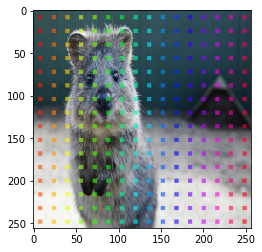

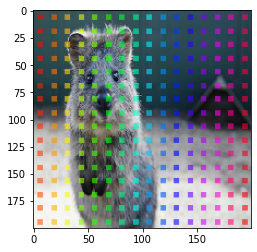

In [139]:
img_aug, kp_aug = transform(image=image, keypoints=kps)

image_before = image
for kp, c in zip(kps, colors):
    image_before = kp.draw_on_image(image_before, size=5, color=c, alpha=.6)

image_after = img_aug
for kp, c in zip(kp_aug, colors):
    image_after = kp.draw_on_image(image_after, size=5, color=c, alpha=.6)

# image_before = kps.draw_on_image(image)
# image_after = kp_aug.draw_on_image(img_aug)

plt.imshow(image_before)
plt.show()
plt.imshow(image_after)
plt.show()

In [12]:
image.shape

(256, 256, 3)

In [75]:
skimage.measure.block_reduce(np.ones([100, 100]), (11,11), np.mean).shape

(10, 10)

In [145]:
kp.x

193.75

In [144]:
Keypoint(x=120, y=0).is_out_of_image((10, 10))

True